In [1]:
# Initailly install the hugging face dataset, only do it in the first time
# pip install datasets
# pip install transformers

In [2]:
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Input
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from datasets import load_dataset
import pandas as pd
import numpy as np
import transformers
from transformers import DistilBertTokenizer

In [3]:
from transformers import TFDistilBertModel

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Download from: kaggle datasets download -d hj5992/restaurantreviews

file_path = "C:\\Users\\WTMH\\Desktop\\AIModel_Final_Project\\Restaurant_Reviews.tsv"

review_data = pd.read_csv(file_path, sep='\t')
review_data.dropna(inplace=True)
review_data = review_data.sample(frac=1,random_state=11)

print(f"Desribe: \n{review_data.describe}")

train_end = 800
test_end = 1000

# Data splitting
train_text=review_data.Review[:train_end]
train_label=review_data.Liked[:train_end]
test_text=review_data.Review[train_end:test_end]
test_label=review_data.Liked[train_end:test_end]

print('Length of Train Data:',train_text.shape[0])
print('Length of Test Data:',test_text.shape[0])

# Show dataset balance
print(train_label.value_counts())
print(test_label.value_counts())

Desribe: 
<bound method NDFrame.describe of                                                 Review  Liked
25   That's right....the red velvet cake.....ohhh t...      1
464    The inside is really quite nice and very clean.      1
372  The dining space is tiny, but elegantly decora...      1
730  The food was barely lukewarm, so it must have ...      0
757                      This is a GREAT place to eat!      1
..                                                 ...    ...
337  The burger... I got the "Gold Standard" a $17 ...      0
91   It's like a really sexy party in your mouth, w...      1
80   Coming here is like experiencing an underwhelm...      0
703  Our server was very nice and attentive as were...      1
921                          This place is disgusting!      0

[1000 rows x 2 columns]>
Length of Train Data: 800
Length of Test Data: 200
1    409
0    391
Name: Liked, dtype: int64
0    109
1     91
Name: Liked, dtype: int64


In [6]:
review_data['Word_Length'] = review_data['Review'].apply(lambda x: len(x.split()))

# Statics about the review length 
print("Word Length Statistics:")
print(review_data['Word_Length'].describe())

Word Length Statistics:
count    1000.000000
mean       10.894000
std         6.257469
min         1.000000
25%         6.000000
50%        10.000000
75%        15.000000
max        32.000000
Name: Word_Length, dtype: float64


In [7]:
train_text_list = train_text.tolist()
test_text_list = test_text.tolist()

In [8]:
# Pretained Tokenizeer 
# https://blog.csdn.net/weixin_42223207/article/details/119336324
# https://huggingface.co/transformers/v3.0.2/model_doc/distilbert.html#transformers.DistilBertTokenizer
# Another class: DistilBertTokenizerFast
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased",do_lower_case=True) 

In [9]:
# a lot of redundent words after tokenizing >> Maybe we should choose the other Tokenizer
text = "I'll say one thing for Jeanette and Nelson--even when stranded in a mirthless, witless, painfully inept musical like this, there's still that twinkle in their eyes. Yes, the chemistry between the famous duo is there even when the material is paper thin."
tokens = tokenizer.tokenize(text)
print(text)
print(tokens)

I'll say one thing for Jeanette and Nelson--even when stranded in a mirthless, witless, painfully inept musical like this, there's still that twinkle in their eyes. Yes, the chemistry between the famous duo is there even when the material is paper thin.
['i', "'", 'll', 'say', 'one', 'thing', 'for', 'jean', '##ette', 'and', 'nelson', '-', '-', 'even', 'when', 'stranded', 'in', 'a', 'mir', '##th', '##less', ',', 'wit', '##less', ',', 'painfully', 'in', '##ept', 'musical', 'like', 'this', ',', 'there', "'", 's', 'still', 'that', 'twinkle', 'in', 'their', 'eyes', '.', 'yes', ',', 'the', 'chemistry', 'between', 'the', 'famous', 'duo', 'is', 'there', 'even', 'when', 'the', 'material', 'is', 'paper', 'thin', '.']


In [10]:
# VERY SLOW 
# Example: encoder: https://huggingface.co/docs/transformers/v4.36.1/en/glossary#input-ids
Maximum_Length = 64
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
          data[i],
          add_special_tokens=True, # add  [CLS] or [SEP]
          max_length=maximum_length,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
        )
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids,train_attention_masks = bert_encode(train_text_list,Maximum_Length) # tokenizer.model_max_length
test_input_ids,test_attention_masks = bert_encode(test_text_list,Maximum_Length)

In [11]:
#Example to show the above encoder

encoder_dict = tokenizer.encode_plus(
          text,
          add_special_tokens=True, # add  [CLS] or [SEP]
          max_length=64,
          padding='max_length', # add [PAD]
          truncation=True,
          return_attention_mask=True,
        )
decode_test = tokenizer.decode(encoder_dict["input_ids"])
print(f'Encode Dict:\n{encoder_dict}')
print(f'Decode:\n{decode_test}')

Encode Dict:
{'input_ids': [101, 1045, 1005, 2222, 2360, 2028, 2518, 2005, 3744, 7585, 1998, 5912, 1011, 1011, 2130, 2043, 15577, 1999, 1037, 14719, 2705, 3238, 1010, 15966, 3238, 1010, 16267, 1999, 23606, 3315, 2066, 2023, 1010, 2045, 1005, 1055, 2145, 2008, 29038, 1999, 2037, 2159, 1012, 2748, 1010, 1996, 6370, 2090, 1996, 3297, 6829, 2003, 2045, 2130, 2043, 1996, 3430, 2003, 3259, 4857, 1012, 102, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]}
Decode:
[CLS] i'll say one thing for jeanette and nelson - - even when stranded in a mirthless, witless, painfully inept musical like this, there's still that twinkle in their eyes. yes, the chemistry between the famous duo is there even when the material is paper thin. [SEP] [PAD] [PAD]


In [12]:
# uncased: do not make a difference between English and other languages
distillBert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [13]:
# Reference1 https://www.kaggle.com/code/colearninglounge/vectorization-embeddings-elmo-bert-gpt/notebook#BERT-Embeddings
# Reference2 http:/www.kaggle.com/code/satyampd/imdb-sentiment-analysis-using-bert-w-huggingface
# Reference3 https://zhuanlan.zhihu.com/p/103226488


def build_model(transformer, max_len=Maximum_Length):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_masks_ids = Input(shape=(max_len,), dtype=tf.int32, name='masked_token')
    sequence_output = transformer([input_word_ids,input_masks_ids])[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=[input_word_ids,input_masks_ids], outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
with tf.device('/GPU:0'):
    model = build_model(distillBert_model)
    model.summary()
    train_input_ids = tf.constant(train_input_ids)
    train_attention_masks = tf.constant(train_attention_masks)
    test_input_ids = tf.constant(test_input_ids)
    test_attention_masks = tf.constant(test_attention_masks)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'Literal' and 'str'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'Literal' and 'str'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_wor

C:\Users\WTMH\anaconda3\envs\tensor_gpu_py37\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
# warning!!　https://github.com/huggingface/transformers/issues/2256
# Not fit the data and model on the gpu, so it's very slow >> set steps_per_epoch/batch_size as small vaule
from tensorflow.keras.callbacks import ModelCheckpoint

BATCH_SIZE = 16

checkpoint = ModelCheckpoint(
    'best_DistillBert_weights.h5', 
    monitor='val_loss',     
    mode='min',
    verbose=1,    
    save_best_only=True,
    save_weights_only=False
)

history = model.fit([train_input_ids,train_attention_masks],train_label,
                    batch_size = BATCH_SIZE ,
                    steps_per_epoch = train_text.shape[0]//BATCH_SIZE,
                    validation_data=([test_input_ids,test_attention_masks],test_label),
                    validation_batch_size=BATCH_SIZE,
                    validation_steps = test_text.shape[0]//BATCH_SIZE,
                    verbose = 2,
                    epochs = 10,
                    callbacks=[checkpoint])

Epoch 1/10
50/50 - 7s - loss: 0.5261 - accuracy: 0.7025 - val_loss: 0.3008 - val_accuracy: 0.8750

Epoch 00001: val_loss improved from inf to 0.30082, saving model to best_DistillBert_weights.h5
Epoch 2/10
50/50 - 4s - loss: 0.2055 - accuracy: 0.9237 - val_loss: 0.1849 - val_accuracy: 0.9271

Epoch 00002: val_loss improved from 0.30082 to 0.18490, saving model to best_DistillBert_weights.h5
Epoch 3/10
50/50 - 4s - loss: 0.0513 - accuracy: 0.9862 - val_loss: 0.1589 - val_accuracy: 0.9271

Epoch 00003: val_loss improved from 0.18490 to 0.15889, saving model to best_DistillBert_weights.h5
Epoch 4/10
50/50 - 4s - loss: 0.0116 - accuracy: 0.9975 - val_loss: 0.1840 - val_accuracy: 0.9375

Epoch 00004: val_loss did not improve from 0.15889
Epoch 5/10
50/50 - 4s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.2008 - val_accuracy: 0.9479

Epoch 00005: val_loss did not improve from 0.15889
Epoch 6/10
50/50 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2041 - val_accuracy: 0.9479

Epoch 00

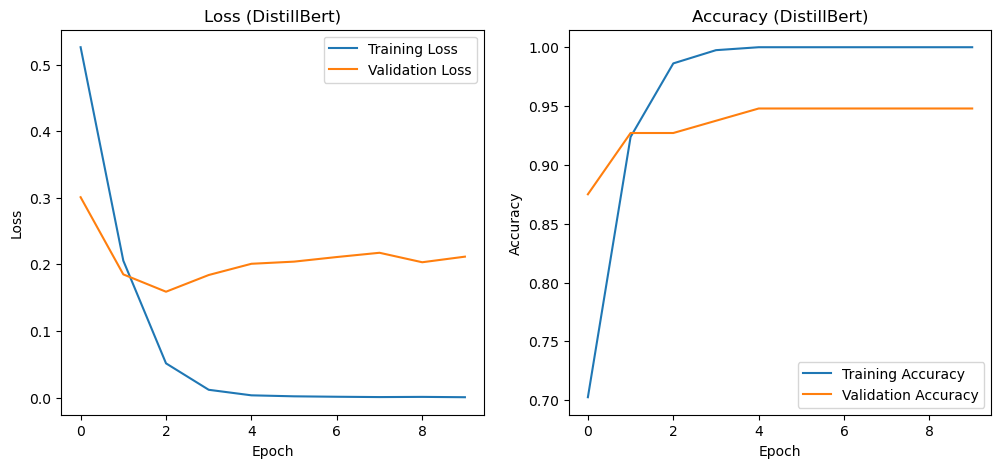

In [16]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss (DistillBert)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy (DistillBert)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
# --------------------Result Test------------------------------------

test1 = "Chefs are nutters. They’re all self-obsessed, delicate, dainty, insecure little souls, and absolute psychopaths. Every last one of them. My gran could do better! And she’s dead!"
test2 = "This dish, my dear friend, is nothing short of a culinary catastrophe. I've never encountered anything quite so disastrous in all my years in the kitchen. The flavors are an absolute train wreck, and the texture is reminiscent of a soggy, overcooked sponge. If this were a competition, it would undoubtedly be a contestant for the 'Worst Dish of the Century' award. An absolute travesty to the world of cuisine!"
test3 = "The culinary delights on offer here are simply extraordinary, with each bite offering an explosion of exquisite flavors that dance harmoniously on the palate, making it an unforgettable and truly gastronomic experience."

# Tokenize the input sentence into a word list, then encode each word in this list
result_input_ids,result_attention_masks = bert_encode([test1,test2,test3],Maximum_Length)

# To tesnor format
input_ids = tf.constant(result_input_ids)
attention_mask = tf.constant(result_attention_masks)

# Feed the encoded lsit into model and predict 
label_map = {0: "Negative", 1: "Positive"}
prob = model([input_ids, attention_mask])
predicted_labels = (prob.numpy() > 0.5).astype(int)

for i, label in enumerate(predicted_labels):
    test_text = [test1, test2, test3][i]
    print(f"Text: '{test_text}'")
    print("Predicted label:", label_map[label[0]], "\n")


Text: 'Chefs are nutters. They’re all self-obsessed, delicate, dainty, insecure little souls, and absolute psychopaths. Every last one of them. My gran could do better! And she’s dead!'
Predicted label: Negative 

Text: 'This dish, my dear friend, is nothing short of a culinary catastrophe. I've never encountered anything quite so disastrous in all my years in the kitchen. The flavors are an absolute train wreck, and the texture is reminiscent of a soggy, overcooked sponge. If this were a competition, it would undoubtedly be a contestant for the 'Worst Dish of the Century' award. An absolute travesty to the world of cuisine!'
Predicted label: Negative 

Text: 'The culinary delights on offer here are simply extraordinary, with each bite offering an explosion of exquisite flavors that dance harmoniously on the palate, making it an unforgettable and truly gastronomic experience.'
Predicted label: Positive 



## Load the trained model and predict

In [18]:
# laod from weights and model
from keras.models import load_model
from transformers import TFDistilBertModel
path = './best_DistillBert_weights.h5'
new_model = load_model(path, custom_objects={'TFDistilBertModel': TFDistilBertModel})

# laod from weights
# path = '.\\best_DistillBert_weights.h5'
# new_model = build_model(distillBert_model)
# new_model.load_weights(path)

In [19]:
test1 = "Chefs are nutters. They’re all self-obsessed, delicate, dainty, insecure little souls, and absolute psychopaths. Every last one of them. My gran could do better! And she’s dead!"
test2 = "This dish, my dear friend, is nothing short of a culinary catastrophe. I've never encountered anything quite so disastrous in all my years in the kitchen. The flavors are an absolute train wreck, and the texture is reminiscent of a soggy, overcooked sponge. If this were a competition, it would undoubtedly be a contestant for the 'Worst Dish of the Century' award. An absolute travesty to the world of cuisine!"
test3 = "The culinary delights on offer here are simply extraordinary, with each bite offering an explosion of exquisite flavors that dance harmoniously on the palate, making it an unforgettable and truly gastronomic experience."

# Tokenize the input sentence into a word list, then encode each word in this list
result_input_ids,result_attention_masks = bert_encode([test1,test2,test3],Maximum_Length)

# To tesnor format
input_ids = tf.constant(result_input_ids)
attention_mask = tf.constant(result_attention_masks)

# Feed the encoded lsit into model and predict 
label_map = {0: "Negative", 1: "Positive"}
prob = new_model([input_ids, attention_mask])
predicted_labels = (prob.numpy() > 0.5).astype(int)

for i, label in enumerate(predicted_labels):
    test_text = [test1, test2, test3][i]
    print(f"Text: '{test_text}'")
    print("Predicted label:", label_map[label[0]], "\n")


Text: 'Chefs are nutters. They’re all self-obsessed, delicate, dainty, insecure little souls, and absolute psychopaths. Every last one of them. My gran could do better! And she’s dead!'
Predicted label: Negative 

Text: 'This dish, my dear friend, is nothing short of a culinary catastrophe. I've never encountered anything quite so disastrous in all my years in the kitchen. The flavors are an absolute train wreck, and the texture is reminiscent of a soggy, overcooked sponge. If this were a competition, it would undoubtedly be a contestant for the 'Worst Dish of the Century' award. An absolute travesty to the world of cuisine!'
Predicted label: Negative 

Text: 'The culinary delights on offer here are simply extraordinary, with each bite offering an explosion of exquisite flavors that dance harmoniously on the palate, making it an unforgettable and truly gastronomic experience.'
Predicted label: Positive 

